In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

%matplotlib inline

In [2]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
d = pd.read_csv('bank_marketing_data_feature_engineered.csv')

In [6]:
d.shape

(41084, 15)

In [7]:
d.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'cons_conf_idx', 'euribor_3_month',
       'deposit', 'age_bucket', 'previous_campaign'],
      dtype='object')

In [9]:
c=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'cons_conf_idx', 'euribor_3_month', 'age_bucket', 'previous_campaign']

In [10]:
X = d[c]

In [140]:
X.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'cons_conf_idx', 'euribor_3_month',
       'age_bucket', 'previous_campaign'],
      dtype='object')

In [11]:
y = d.deposit

In [12]:
X.shape

(41084, 14)

In [13]:
y.shape

(41084,)

In [152]:
#### Checking Lasso and Ridge

In [153]:
#optimal lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.004960468965202983


.............................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [154]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[-0.08517642 -0.03233033 -0.05767556 -0.06820438 -0.01834665 -0.0858082
 -0.07732901 -0.13490956 -0.02084661 -0.38165977]
-0.09622864930559993


In [155]:
lasso.fit(Xs, y)

Lasso(alpha=0.004960468965202983, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [156]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef,abs_coef
11,euribor_3_month,-0.095739,0.095739
10,cons_conf_idx,0.039348,0.039348
13,previous_campaign,0.010820,0.010820
7,month,0.009141,0.009141
3,default,-0.006016,0.006016
6,contact,0.005920,0.005920
1,marital,-0.001163,0.001163
9,campaign,-0.000839,0.000839
0,job,0.000000,0.000000
2,education,0.000000,0.000000


In [157]:
#### Ridge

In [158]:
#optimal ridge
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

31440.354715915


In [159]:
#cross-validate r2
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[-9.95888993e-02 -4.21771930e-02 -6.67475031e-03  1.65638515e-04
 -1.00391135e-02 -1.02134894e-01 -5.45515277e-02 -5.61916920e-02
  9.33585628e-03 -5.14064916e-01]
-0.0875921491157339


In [160]:
ridge.fit(Xs, y)

Ridge(alpha=31440.354715915, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [161]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs

,variable,coef,abs_coef
11,euribor_3_month,-0.048474,0.048474
10,cons_conf_idx,0.019599,0.019599
13,previous_campaign,0.019372,0.019372
6,contact,0.013002,0.013002
3,default,-0.010165,0.010165
9,campaign,-0.006249,0.006249
1,marital,-0.005562,0.005562
7,month,0.004539,0.004539
12,age_bucket,0.003597,0.003597
0,job,0.002889,0.002889


In [165]:
## Taking top 5 features from lasso, Ridge, F classif, chi2

#### Taking top 10 features from Ridge

In [14]:
c = ['euribor_3_month', 'previous_campaign', 'marital', 'month', 'age_bucket', 'job', 'default', 'campaign', 'contact', 'cons_conf_idx']

In [15]:
X = d[c]

In [16]:
X.columns

Index(['euribor_3_month', 'previous_campaign', 'marital', 'month',
       'age_bucket', 'job', 'default', 'campaign', 'contact', 'cons_conf_idx'],
      dtype='object')

In [17]:
y = d.deposit

In [18]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33, random_state=0, stratify = y)

In [21]:
print("Number Of Observations X_train dataset: ", X_train.shape)
print("Number Of Observations y_train dataset: ", y_train.shape)
print("Number Of Observations X_test dataset: ", X_test.shape)
print("Number Of Observations y_test dataset: ", y_test.shape)

Number Of Observations X_train dataset:  (27526, 10)
Number Of Observations y_train dataset:  (27526,)
Number Of Observations X_test dataset:  (13558, 10)
Number Of Observations y_test dataset:  (13558,)


In [22]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 3109
Before OverSampling, counts of label '0': 24417 



In [23]:
sm = SMOTE(random_state=2)
X_train_resample, y_train_resample = sm.fit_sample(X_train, y_train.ravel())

In [24]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_resample.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resample.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_resample==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_resample==0)))

After OverSampling, the shape of train_X: (48834, 10)
After OverSampling, the shape of train_y: (48834,) 

After OverSampling, counts of label '1': 24417
After OverSampling, counts of label '0': 24417


In [25]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_resample, y_train_resample.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done  45 out of  50 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.7s finished
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [26]:
clf.best_params_

{'C': 1.0}

In [27]:
clf.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Checking different models with the selected features

In [29]:
lr = LogisticRegression(C=1, verbose=0)
lr.fit(X_train_resample, y_train_resample.ravel())

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
cross_val_score(lr, X_train_resample, y_train_resample, cv =5)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

array([0.71867322, 0.71590909, 0.72486177, 0.71318861, 0.71267663])

In [31]:
lr.fit(X_train_resample, y_train_resample)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
yhat = lr.predict(X_test)

In [33]:
print(confusion_matrix(y_test, yhat))

[[8760 3267]
 [ 470 1061]]


In [34]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82     12027
           1       0.25      0.69      0.36      1531

   micro avg       0.72      0.72      0.72     13558
   macro avg       0.60      0.71      0.59     13558
weighted avg       0.87      0.72      0.77     13558



In [35]:
lr.score(X_test, y_test)

0.7243693760141614

In [36]:
tmp = lr.fit(X_train_resample, y_train_resample)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


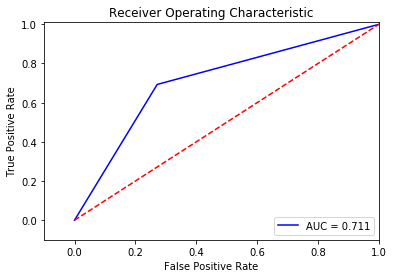

In [37]:

fpr, tpr, thresholds = roc_curve(y_test, yhat)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

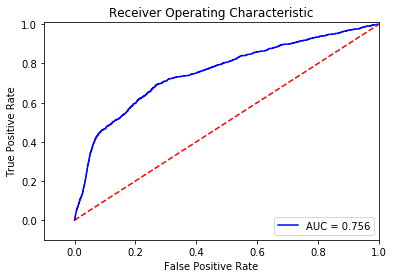

In [38]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
rf1 = RandomForestClassifier(n_estimators=100)

In [40]:
rf1.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
cross_val_score(rf1, X_train_resample, y_train_resample, cv = 5)

array([0.80446355, 0.9465602 , 0.94347737, 0.94603727, 0.94603727])

In [42]:
yhatr = rf1.predict(X_test)

In [43]:
rf1.score(X_test,y_test)

0.8635491960466145

In [44]:
confusion_matrix(y_test, yhatr)

array([[11160,   867],
       [  983,   548]], dtype=int64)

In [45]:
print(classification_report(y_test, yhatr))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     12027
           1       0.39      0.36      0.37      1531

   micro avg       0.86      0.86      0.86     13558
   macro avg       0.65      0.64      0.65     13558
weighted avg       0.86      0.86      0.86     13558



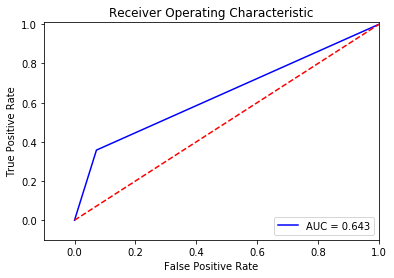

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, yhatr)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
from xgboost import XGBClassifier

In [48]:
xg = XGBClassifier(n_estimators=100)

In [49]:
cross_val_score(xg, X_train_resample, y_train_resample, cv = 5)

array([0.77907453, 0.88011876, 0.8827565 , 0.88398525, 0.87599836])

In [50]:
mdl = xg.fit( X_train_resample, y_train_resample)

In [51]:
yhatx = mdl.predict(X_test)

In [52]:
xg.score(X_test, y_test)

0.8622953237940699

In [53]:
confusion_matrix(y_test, yhatx)

array([[10873,  1154],
       [  713,   818]], dtype=int64)

In [54]:
print(classification_report(y_test, yhatx))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12027
           1       0.41      0.53      0.47      1531

   micro avg       0.86      0.86      0.86     13558
   macro avg       0.68      0.72      0.69     13558
weighted avg       0.88      0.86      0.87     13558



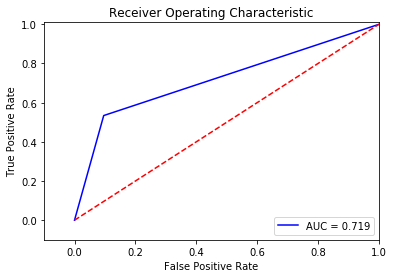

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, yhatx)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train_resample, y_train_resample, cv =5)

array([0.81183456, 0.85370598, 0.85746467, 0.85398321, 0.85377841])

In [57]:
knn.fit(X_train_resample, y_train_resample)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [230]:
knn.score(X_test, y_test)

0.816323219211423

In [231]:
yhatk = knn.predict(X_test)

In [232]:
confusion_matrix(y_test, yhatk)

array([[9388, 1546],
       [ 718,  674]], dtype=int64)

In [233]:
print(classification_report(y_test, yhatk))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     10934
           1       0.30      0.48      0.37      1392

   micro avg       0.82      0.82      0.82     12326
   macro avg       0.62      0.67      0.63     12326
weighted avg       0.86      0.82      0.83     12326



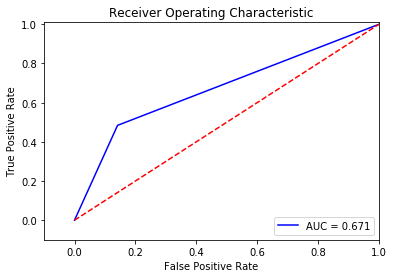

In [235]:
fpr, tpr, thresholds = roc_curve(y_test, yhatk)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [59]:
sv = LinearSVC()

In [61]:
cross_val_score(sv, X_train_resample, y_train_resample, cv =10)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

array([0.72686323, 0.71027846, 0.70925471, 0.72215397, 0.72870598,
       0.72215397, 0.71457821, 0.71200328, 0.71241295, 0.71589512])

In [62]:
sv.fit(X_train_resample, y_train_resample)

C:\Users\r_ani\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [63]:
yhatc = sv.predict(X_test)

In [64]:
sv.score(X_test, y_test)

0.7200914589172445

In [65]:
confusion_matrix(y_test, yhatc)

array([[8695, 3332],
       [ 463, 1068]], dtype=int64)

In [66]:
print(classification_report(y_test, yhatc))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     12027
           1       0.24      0.70      0.36      1531

   micro avg       0.72      0.72      0.72     13558
   macro avg       0.60      0.71      0.59     13558
weighted avg       0.87      0.72      0.77     13558



In [67]:
score_pred_y = sv.decision_function(X_test)

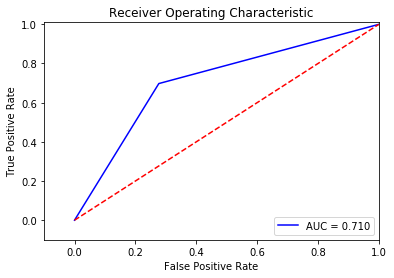

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, yhatc)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

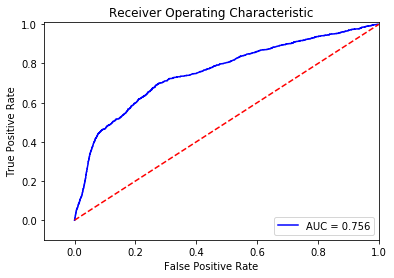

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, score_pred_y)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Next will try with best features from Random forest feature importance - TOP 10